In [1]:
%load_ext autoreload
%autoreload 2

In [277]:
import torch
import clip
from PIL import Image
from pathlib import Path
import pandas as pd
from IPython.display import display
from PIL.ImageDraw import ImageDraw
from tqdm import tqdm
from figural.scoring import autoset_device, FiguralImage, preprocess_imlist, image_loader, collage, get_avg_sims, similarity_to_target

In [3]:
device = autoset_device()
model, preprocess = clip.load("ViT-B/32", device=device)

CLIP doesn't work on M1 GPUs yet; check here for updates: https://github.com/openai/CLIP/issues/247


In [4]:
impaths = dict()
print('Directories of images:', end='\t')
for subdir in Path('../data/outputs/test1').iterdir():
    if subdir.name.startswith('activity'):
        imgs = list(subdir.glob('*jpg'))
        impaths[subdir.name] = imgs
        print(subdir.name, f"({len(imgs)} files)", end='\t')
print()

Directories of images:	activity2b (452 files)	activity2e (452 files)	activity2j (452 files)	activity2d (452 files)	activity2c (452 files)	activity2f (452 files)	activity2a (452 files)	activity2h (452 files)	activity2i (452 files)	activity2g (452 files)	activity1 (415 files)	


## Testing CLIP 

In [5]:
i = 23

24


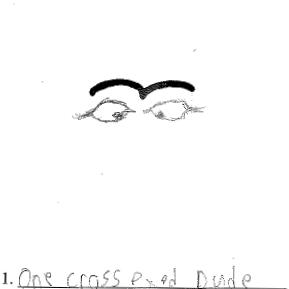

In [6]:
i += 1
print(i)
impath = impaths['activity2a'][i]
Image.open(impath)

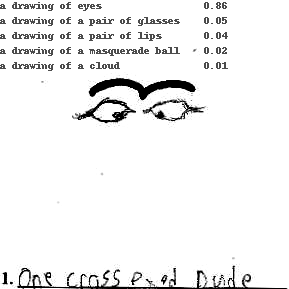

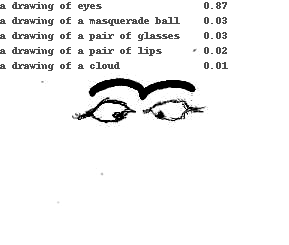

In [16]:
pil_inputs = [FiguralImage(impath).contrast(3).im, FiguralImage(impath).contrast(3).crop(0.85).im]
image_inputs = preprocess_imlist(pil_inputs, preprocess, device=device)

labels = ["a bird", "a girl", "a dog", "a cat", "eyes", "a sunset", "a heart", "love", "a cherry", "a cloud",
"a pair of glasses", "the sky", "a boy", "a flock of birds", "a pair of lips", "a flock of seagulls", "Toby", "a bikini", "a bone",
"a cartoon snake", "a masquerade ball", "a broken heart", "a cartoon man", "a man", "a book", "ice cream", "a pizza", "a cartoon pizza",
"a Ninja Turtle", "an ant", "a flower"]
# notes:
# 'cartoon snake' works better than 'snake'; try for many options
labels = [f"a drawing of {x}" for x in labels]
#labels = ["a broken heart", "a drawing of a broken heart", "a drawing of a cartoon broken heart", "a cartoon broken heart"]
text = clip.tokenize(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image_inputs, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for j, im in enumerate(pil_inputs):
    probs_s = pd.Series(probs[j], index=labels).round(2).sort_values(ascending=False)
    plaintxt = probs_s.head(5).__repr__()[::-1].split('\n', 1)[1][::-1]
    a = im.copy()
    draw = ImageDraw(a)
    draw.text((0,0), plaintxt, fill='Red')
    display(a)

I wonder... can we take the text features of all the known images, then for each image, calculate the average distance from all of them?

## Scoring Method 1 - Average Similarity

Take similarity of each known image to each other, and see an average similarity. The idea being - high avg similarity means your response look a great deal like past responses.

In [133]:
collector = []
for activity in tqdm(impaths.keys()):
    imloader = image_loader(impaths[activity], contrast_factor=4, crop_bottom=True)
    image_inputs = preprocess_imlist(imloader, preprocess, device=device)
    sims = get_avg_sims(image_inputs, model, idx=impaths[activity]).reset_index()
    sims.columns = ['path', 'avg_sim']
    sims['booklet'] = 'BOOKLETA'
    sims['activity'] = activity
    collector.append(sims)

df = pd.concat(collector)
df['id'] = df.path.apply(lambda x: x.stem)
df.path = df.path.apply(lambda x: str(x))
df.to_parquet('../data/avg_sims.parquet', compression='snappy')
df.sample()

,path,avg_sim,booklet,activity,id
333,../data/outputs/test1/activity2h/fd6d5-71624.jpg,0.830225,BOOKLETA,activity2h,fd6d5-71624


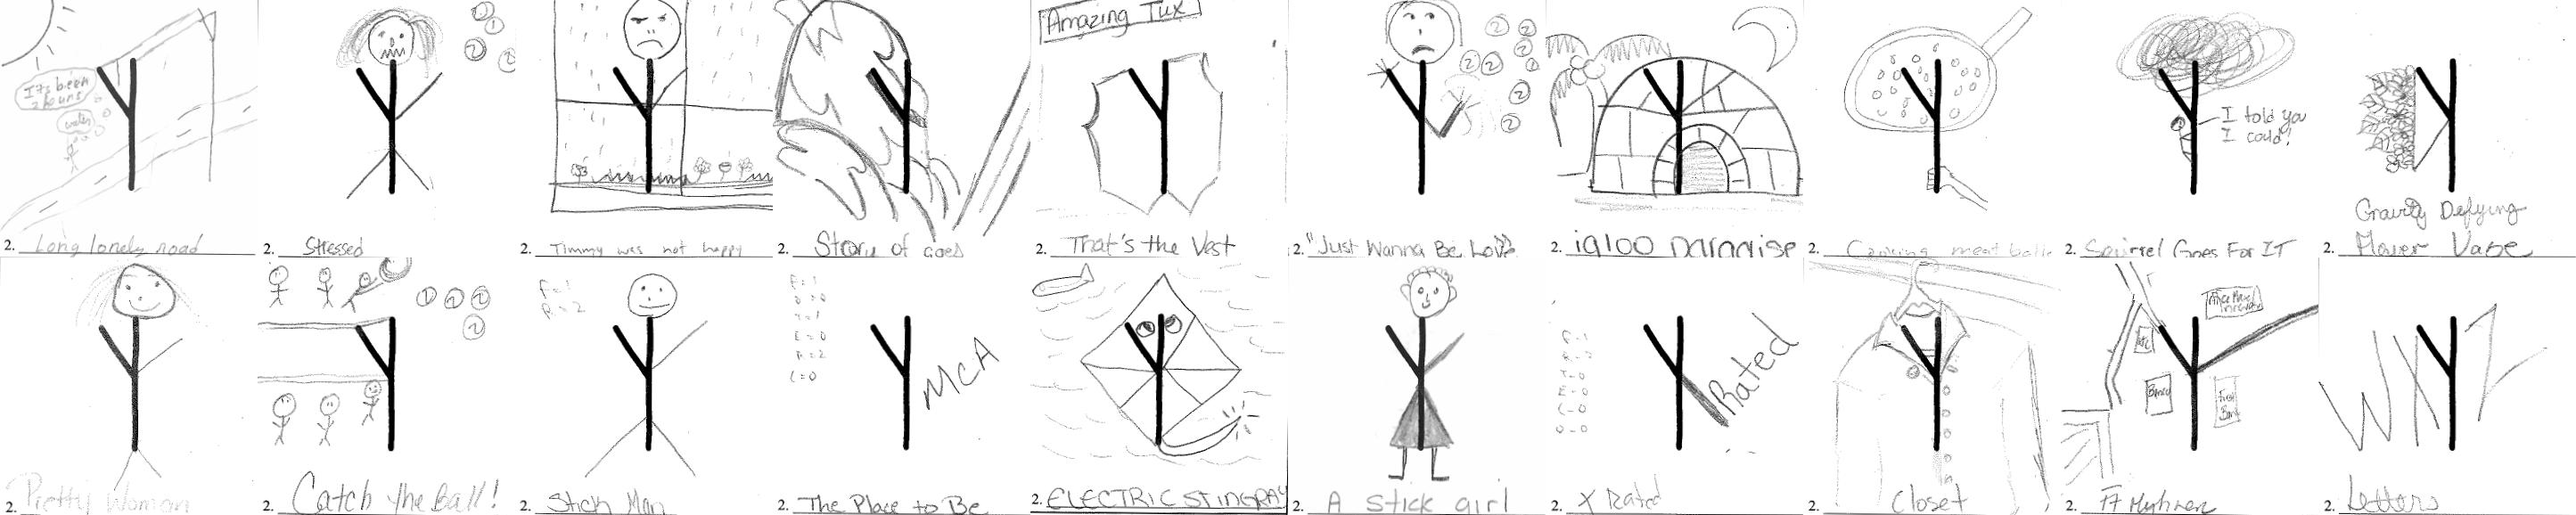

In [130]:
most_original = collage(df.query('activity == "activity2b"').sort_values('avg_sim').path.tolist(), cols=10, rows=2) # don't specify rows to show *all*
most_original

## Elaboration Method 1

Use ink amount. For correction, look at the average of the ink of _n_ least-inked images to set a minimum, and correct elaboration against the baseline. The 'least-ink' images should be blank, un-filled out images. In case of cropping errors I don't want to just save the lowest ink pic.

In [131]:
im = FiguralImage(impath)
im.elaboration()

0.032

In [138]:
collector = []
for activity in tqdm(impaths.keys()):
    for path in impaths[activity]:
        im = FiguralImage(path)
        elab = im.elaboration(raw=True)
        row = dict(path=str(path), id=path.stem, booklet='BOOKLETA', elaboration_raw=elab, activity=activity)
        collector.append(row)
df = pd.DataFrame(collector)

def elaboration_correction(x):
    total_pixels = 40000
    # take avg of 5 least-inked images
    min_ink = x.sort_values().head(5).mean().astype(int)
    prop_ink = (x-min_ink).clip(lower=0) / (total_pixels-min_ink)
    return prop_ink

df['elaboration'] = df.groupby('activity').elaboration_raw.transform(elaboration_correction)
df.to_parquet('../data/elaboration.parquet', compression='snappy')

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


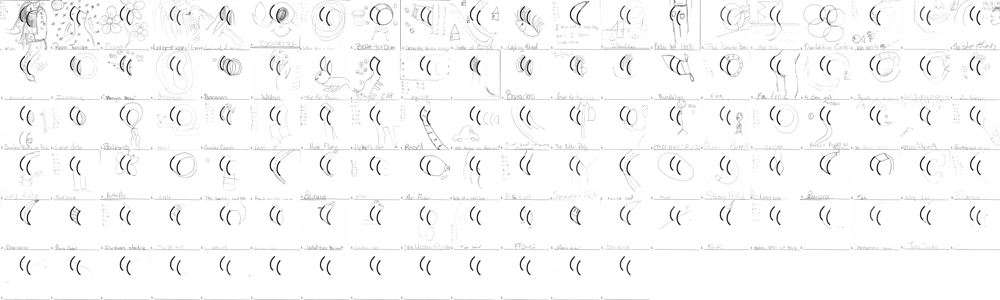

In [240]:
# every 4th image, most to least ink
collage(df[df.activity == 'activity2c'].sort_values('elaboration').path.tolist()[::-4], 20, thumbnail=(1000,1000))

Sanity check: are the _n_ least-inked images actually blank?

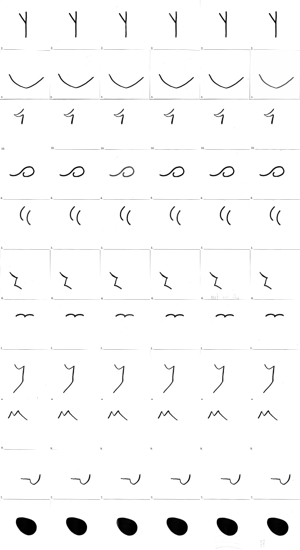

In [241]:
n, s = 6, 50
bigim = Image.new(mode='RGB', size=(n*s,s*len(impaths.keys())), color='white')
for i, activity in enumerate(impaths.keys()):
    x = collage(df[df.activity == activity].sort_values('elaboration_raw').head(n).path, cols=n, rows=1, thumbnail=(n*s,n*s))
    bigim.paste(x, (0, i*s))
bigim

### Save blank images

Also, save an example blank image for every activity - this will be useful later.

In [246]:
n = 5
min_ink = df.groupby(['booklet', 'activity']).elaboration_raw.apply(lambda x: x.sort_values().head(n).mean()).astype(int).reset_index()
# save third lowest ink value
example_blank = df.groupby(['booklet', 'activity']).apply(lambda x: x.sort_values('elaboration_raw').iloc[(n-1)//2].path)
example_blank.name = 'blank_ex'
activity_info = min_ink.merge(example_blank.reset_index()).rename(columns={'elaboration_raw':'min_ink'})
activity_info.to_parquet('../data/activity_info.parquet', compression='snappy')

## Scoring Method 2 - Similarity to blank

In [290]:
collector = []
blank_info = activity_info.set_index('activity').blank_ex.to_dict()

for activity in tqdm(impaths.keys()):
    imloader = image_loader(impaths[activity], contrast_factor=4, crop_bottom=True)
    image_inputs = preprocess_imlist(imloader, preprocess, device=device)
    sims = similarity_to_target(image_inputs, blank_info[activity], model, preprocess, device, idx=impaths[activity]).reset_index()
    sims.columns = ['path', 'blank_sim']
    sims['booklet'] = 'BOOKLETA'
    sims['activity'] = activity
    collector.append(sims)

df = pd.concat(collector)
df['id'] = df.path.apply(lambda x: x.stem)
df.path = df.path.apply(lambda x: str(x))
df.to_parquet('../data/sims_to_blank.parquet', compression='snappy')
df.sample()

100%|██████████| 11/11 [02:33<00:00, 13.92s/it]


,path,blank_sim,booklet,activity,id
247,../data/outputs/test1/activity2g/68332-71787_U...,0.829345,BOOKLETA,activity2g,68332-71787_Unmatched


### Combine outputs

Save to CSV for sharing with others.

In [300]:
blanksim = pd.read_parquet('../data/sims_to_blank.parquet')
avgsim = pd.read_parquet('../data/avg_sims.parquet')
elab = pd.read_parquet('../data/elaboration.parquet')
combined = blanksim.merge(avgsim).merge(elab)
combined.to_csv('../data/ttct_figural_booka_stats.csv')

## Calculate Cronbach's alpha

In [352]:
import pingouin

def feature_ablation_alpha(df, score_col):
    '''Calculate full Cronbach's alpha, as well as how much removing a specific item changes it'''
    fullalpha, ci = pingouin.cronbach_alpha(df, items='activity', scores=score_col, subject='id')
    print(f"Full Alpha: {fullalpha:.4f}")
    itemcols = combined['activity'].sort_values().unique()
    for exclude_item in itemcols:
        subset = df[df.activity != exclude_item]
        alpha, ci = pingouin.cronbach_alpha(subset, items='activity', scores=score_col, subject='id')
        diff = alpha-fullalpha
        diffsign = '+' if diff > 0 else '-'
        print(f"\tw/o {exclude_item}:\t{alpha:.4f} ({diffsign}{abs(diff):.4f})")

In [378]:
q = 0.2
for q in np.arange(0.00, 0.25, 0.05):
    print(f"Elab {q:.02f} quantile: {combined.elaboration.quantile(q):.4f}")

    excluding_blank = combined[combined.elaboration > combined.elaboration.quantile(q)]
    for metric in ['elaboration', 'avg_sim', 'blank_sim']:
        alpha, ci = pingouin.cronbach_alpha(excluding_blank, items='activity', scores=metric, subject='id')
        print(f"\t{metric}:\t{alpha:.4f}")

Elab 0.00 quantile: 0.0000
	elaboration:	0.7486
	avg_sim:	0.5762
	blank_sim:	0.6398
Elab 0.05 quantile: 0.0010
	elaboration:	0.7589
	avg_sim:	0.5927
	blank_sim:	0.6124
Elab 0.10 quantile: 0.0041
	elaboration:	0.7724
	avg_sim:	0.6130
	blank_sim:	0.6305
Elab 0.15 quantile: 0.0088
	elaboration:	0.7736
	avg_sim:	0.6192
	blank_sim:	0.6444
Elab 0.20 quantile: 0.0128
	elaboration:	0.7657
	avg_sim:	0.6105
	blank_sim:	0.6106


-------ELABORATION-------
0.7657022732093174
---------AVG_SIM---------
0.6104876483530257
--------BLANK_SIM--------
0.6105944981768534


In [353]:
for metric in ['elaboration', 'avg_sim', 'blank_sim']:
    print(metric.upper().center(25, '-'))
    feature_ablation_alpha(combined, metric)

-------ELABORATION-------
Full Alpha: 0.7488
	w/o activity1:	0.7275 (-0.0213)
	w/o activity2a:	0.7306 (-0.0182)
	w/o activity2b:	0.7389 (-0.0099)
	w/o activity2c:	0.7285 (-0.0203)
	w/o activity2d:	0.7290 (-0.0198)
	w/o activity2e:	0.7329 (-0.0159)
	w/o activity2f:	0.7329 (-0.0159)
	w/o activity2g:	0.7258 (-0.0230)
	w/o activity2h:	0.7307 (-0.0181)
	w/o activity2i:	0.7226 (-0.0262)
	w/o activity2j:	0.7350 (-0.0138)
---------AVG_SIM---------
Full Alpha: 0.5719
	w/o activity1:	0.5537 (-0.0182)
	w/o activity2a:	0.5332 (-0.0387)
	w/o activity2b:	0.5538 (-0.0180)
	w/o activity2c:	0.5401 (-0.0317)
	w/o activity2d:	0.5483 (-0.0236)
	w/o activity2e:	0.5488 (-0.0230)
	w/o activity2f:	0.5368 (-0.0350)
	w/o activity2g:	0.5381 (-0.0337)
	w/o activity2h:	0.5534 (-0.0184)
	w/o activity2i:	0.5744 (+0.0025)
	w/o activity2j:	0.5499 (-0.0219)
--------BLANK_SIM--------
Full Alpha: 0.6442
	w/o activity1:	0.6264 (-0.0178)
	w/o activity2a:	0.6291 (-0.0151)
	w/o activity2b:	0.6406 (-0.0036)
	w/o activity2c:	0